## Press Shift+Enter to run the cells ↓↓
Execute in sequential order

In [1]:
#@title 1. Package Install+Import

!pip install -q colour-science
!pip install -q tabulate

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Markdown
from google.colab import output
import sys
import colour
from colour.plotting import *
from tabulate import tabulate
import sympy as smp

output.no_vertical_scroll() # avoids nested scrollbars

%config InlineBackend.figure_format = 'svg'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

In [2]:
#@title 2. GitHub Data Retrieval

# Grab the files from GitHub
!git clone https://github.com/tjz21/DAC_Color.git

Cloning into 'DAC_Color'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 80 (delta 30), reused 74 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 1.20 MiB | 6.93 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
#@title 3. Define Color Functions

output.no_vertical_scroll()

def color_difference(R1, G1, B1, R2, G2, B2):
  '''Elucidean distance between two colors. Uses CIE 1976 distance formula.

  Works equally well for RGB CIE L*a*b* coordinates.

  :param R1: Red component of second color
  :param G1: Green component of first color
  :param B1: Blue component of first color
  :param R2: Idem for second color
  :param G2: Idem for second color
  :param B2: Idem for second color

  '''
  coor1 = np.array([R1, G1, B1])
  coor2 = np.array([R2, G2, B2])
  difference = (coor2 - coor1)**2
  difference = np.sqrt(difference.sum())
  return np.round(difference, 2)

def chroma_hue(L, a, b):
  '''Calculates chroma and hue from L*a*b* coordinates.

  :param L: Lightness
  :param a: Green-Red component
  :param b: Blue-Yellow component
  :return: Tuple of chroma and hue (in degrees)
  '''
  C = np.sqrt(a**2 + b**2)
  H = np.arctan2(b, a) * 180 / np.pi
  if H < 0:
    H = H + 360
  return np.round((C, H), 2)

def CIELAB_to_sRGB(L, a, b, title='Sample'):
  '''Converts CIE L*a*b* to sRGB.

  :param L: Lightness
  :param a: Green-Red component
  :param b: Blue-Yellow component
  :param title: Title of plot
  '''
  cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"] # standard observer
  illuminant = colour.SDS_ILLUMINANTS["D65"] # standard daylight illuminant
  XYZ = colour.Lab_to_XYZ(np.array([L, a, b]), illuminant=colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65'])
  RGB = colour.XYZ_to_sRGB(XYZ)
  RGB = np.clip(RGB, 0, 1) # RGB 0-1
  RGB_255 = np.int64(np.round((RGB)*255, 0)) # RGB 0-255
  print(f"L*:{L} a*:{a} b*:{b} → R:{RGB_255[0]} G:{RGB_255[1]} B:{RGB_255[2]}")
  plot_single_colour_swatch(ColourSwatch(RGB, f"{title}\nR:{RGB_255[0]}\nG:{RGB_255[1]}\nB:{RGB_255[2]}"), text_kwargs={"size": 50})
  display(Markdown(rf'# L\*:{L} a\*:{a} b\*:{b}'))


def color_calc_exp(filename, energy_units='nm', data_type='reflect', title='Sample'):
  '''Calculates color from experimental reflectance or absorbance curve.

  A D65 illuminant and CIE 1931 2 degree Standard Observer as assumed (both can be changed).

  :param filename: filename with .csv extension
  :param energy_units: 'nm' or 'ev'
  :param data_type: 'reflect' or 'absorbance'
  :param title: Title of plot
  :return: None
  '''
  data = np.loadtxt(f'{filename}', skiprows=1, delimiter=',')
  if energy_units == 'nm':
    energy = data[:,0]
  elif energy_units == 'ev':
    energy = 1239.84193 / data[:,0]
  else:
    raise ValueError("Invalid energy units. Choose 'nm' or 'ev'.")

  if data_type == 'reflect':
    reflect = data[:,1]
    reflect = reflect / 100
  elif data_type == 'absorbance':
    absorbance = data[:,1]
    reflect = (absorbance + 1) - 0.5 * np.sqrt(4*(absorbance+1)**2 - 4)
  else:
    raise ValueError("Invalid data type. Choose 'reflect' or 'absorbance'.")

  sd_format = dict(zip(np.flip(energy), np.flip(reflect)))
  sd = colour.SpectralDistribution(sd_format)
  sd.interpolate(shape=colour.SpectralShape(380, 780, 1))
  cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
  illuminant = colour.SDS_ILLUMINANTS["D65"]
  XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
  CIE = np.round(colour.XYZ_to_Lab(XYZ / 100), 2)
  xy = colour.XYZ_to_xy(XYZ / 100)
  xy = np.round(xy, 4)
  RGB = colour.XYZ_to_sRGB(XYZ / 100)
  RGB = np.round((RGB), 4)
  RGB_coordinates = np.int64(np.round(((RGB) * 255), 0))
  RGB = np.clip(RGB, 0, 1)
  RGB_coordinates = np.clip(RGB_coordinates, 0, 255)
  plot_single_sd(sd, title=title, text_kwargs={"size": 38})
  plot_single_colour_swatch(ColourSwatch(RGB, f"{title}\nR:{RGB_coordinates[0]}\nG:{RGB_coordinates[1]}\nB:{RGB_coordinates[2]}"), text_kwargs={"size": 50})
  display(Markdown(rf'# CIE 1976 L\*a\*b\*'))
  display(Markdown(rf'## L\*:{CIE[0]} a\*:{CIE[1]} b\*:{CIE[2]}'))
  display(Markdown(rf'# CIE 1931 x,y'))
  display(Markdown(rf'## x:{xy[0]} y:{xy[1]}'))
  display(Markdown('---'))

def color_calc_comp(filename, energy_units='nm', data_type='reflect', title='Sample', scale=1):
  '''Calculates color from computational absorbance curve.

  A D65 illuminant and CIE 1931 2 degree Standard Observer as assumed (both can be changed).

  :param filename: filename with .txt extension
  :param energy_units: 'nm' or 'ev'
  :param data_type: 'reflect' or 'absorbance'
  :param title: Title of plot
  :param scale: Scale factor for absorbance (after normalizing)
  :return: None
  '''

  data = np.loadtxt(f'{filename}', skiprows=2)
  if energy_units == 'nm':
    energy = data[:,0]
  elif energy_units == 'ev':
    energy = 1239.84193 / data[:,0]
  else:
    raise ValueError("Invalid energy units. Choose 'nm' or 'ev'.")

  if data_type == 'reflect':
    reflect = data[:,1]
    reflect = reflect / 100
  elif data_type == 'absorbance':
    absorbance = data[:,1] / data[:,1].max()
    reflect = (scale*absorbance + 1) - 0.5 * np.sqrt(4*(scale*absorbance+1)**2 - 4)
  else:
    raise ValueError("Invalid data type. Choose 'reflect' or 'absorbance'.")

  sd_format = dict(zip(energy, reflect))
  sd = colour.SpectralDistribution(sd_format)
  sd.interpolate(shape=colour.SpectralShape(380, 780, 1))
  cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
  illuminant = colour.SDS_ILLUMINANTS["D65"]
  XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
  CIE = np.round(colour.XYZ_to_Lab(XYZ / 100), 2)
  xy = colour.XYZ_to_xy(XYZ / 100)
  xy = np.round(xy, 4)
  RGB = colour.XYZ_to_sRGB(XYZ / 100)
  RGB = np.round((RGB), 4)
  RGB_coordinates = np.int64(np.round(((RGB) * 255), 0))
  RGB = np.clip(RGB, 0, 1)
  RGB_coordinates = np.clip(RGB_coordinates, 0, 255)
  plot_single_sd(sd, title=title, text_kwargs={"size": 38})
  plot_single_colour_swatch(ColourSwatch(RGB, f"{title}\nR:{RGB_coordinates[0]}\nG:{RGB_coordinates[1]}\nB:{RGB_coordinates[2]}"), text_kwargs={"size": 50})
  display(Markdown(rf'# CIE 1976 L\*a\*b\*'))
  display(Markdown(rf'## L\*:{CIE[0]} a\*:{CIE[1]} b\*:{CIE[2]}'))
  display(Markdown(rf'# CIE 1931 x,y'))
  display(Markdown(rf'## x:{xy[0]} y:{xy[1]}'))
  display(Markdown('---'))

display(Markdown('''

<left>

| Function Name     | Purpose                                                                 | Inputs                               | Output / Behavior                                      |
|-------------------|:-------------------------------------------------------------------------:|--------------------------------------|--------------------------------------------------------|
| color_difference  | Computes Euclidean distance between two colors (RGB or LAB).            | R1, G1, B1, R2, G2, B2               | Returns scalar color difference (float).               |
| chroma_hue        | Calculates chroma and hue from CIE L a b coordinates.                   | L, a, b                              | Returns tuple: (chroma, hue in degrees).               |
| CIELAB_to_sRGB    | Converts CIE L a b to sRGB and displays color swatch.                   | L, a, b, title                       | Prints RGB values, plots color swatch.                 |
| color_calc_exp    | Computes color from experimental reflectance/absorbance data.           | filename (.csv)                      | Displays LAB, xy, RGB values and plots.                |
| color_calc_comp   | Computes color from computational absorbance data with scaling option.  | filename (.txt)                      | Displays LAB, xy, RGB values and plots.                |

<left/>

'''
))


<IPython.core.display.Javascript object>

 

<left>

| Function Name     | Purpose                                                                 | Inputs                               | Output / Behavior                                      |
|-------------------|:-------------------------------------------------------------------------:|--------------------------------------|--------------------------------------------------------|
| color_difference  | Computes Euclidean distance between two colors (RGB or LAB).            | R1, G1, B1, R2, G2, B2               | Returns scalar color difference (float).               |
| chroma_hue        | Calculates chroma and hue from CIE L a b coordinates.                   | L, a, b                              | Returns tuple: (chroma, hue in degrees).               |
| CIELAB_to_sRGB    | Converts CIE L a b to sRGB and displays color swatch.                   | L, a, b, title                       | Prints RGB values, plots color swatch.                 |
| color_calc_exp    | Computes color from experimental reflectance/absorbance data.           | filename (.csv)                      | Displays LAB, xy, RGB values and plots.                |
| color_calc_comp   | Computes color from computational absorbance data with scaling option.  | filename (.txt)                      | Displays LAB, xy, RGB values and plots.                |

<left/>



<IPython.core.display.Javascript object>

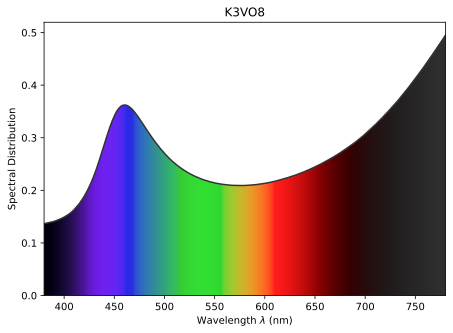

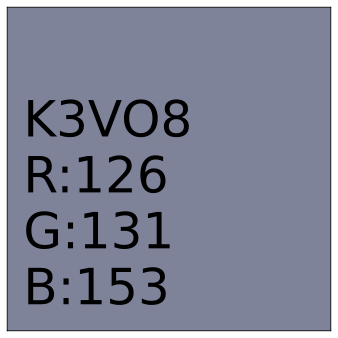

# CIE 1976 L\*a\*b\*

## L\*:54.86 a\*:3.06 b\*:-12.42

# CIE 1931 x,y

## x:0.2851 y:0.2911

---

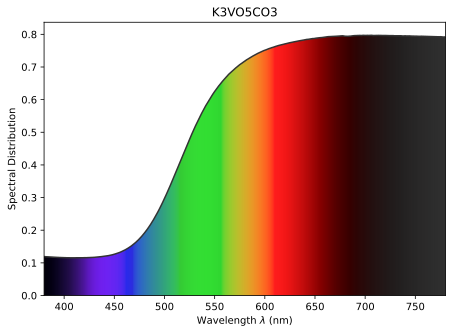

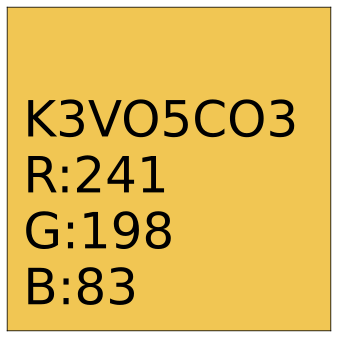

# CIE 1976 L\*a\*b\*

## L\*:81.64 a\*:3.25 b\*:61.25

# CIE 1931 x,y

## x:0.4317 y:0.4438

---

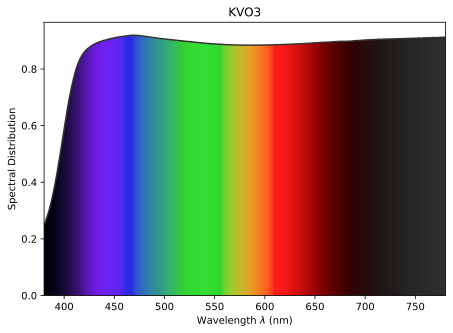

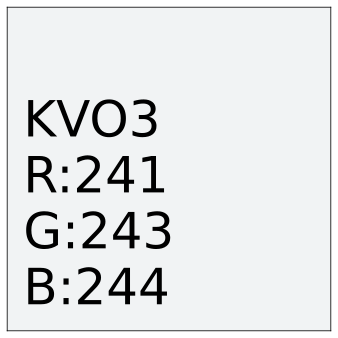

# CIE 1976 L\*a\*b\*

## L\*:95.63 a\*:-0.39 b\*:-0.71

# CIE 1931 x,y

## x:0.3109 y:0.3279

---

In [4]:
#@title 4. Experimental Colors

output.no_vertical_scroll()

color_calc_exp('DAC_Color/experimental/K3VO8_reflect.csv', title='K3VO8', energy_units='nm', data_type='reflect')
color_calc_exp('DAC_Color/experimental/K3VO5CO3_reflect.csv', title='K3VO5CO3', energy_units='nm', data_type='reflect')
color_calc_exp('DAC_Color/experimental/KVO3_reflect.csv', title='KVO3', energy_units='nm', data_type='reflect')

<IPython.core.display.Javascript object>

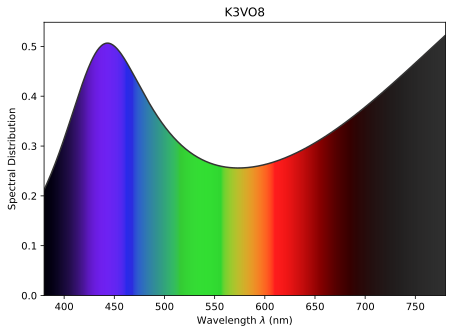

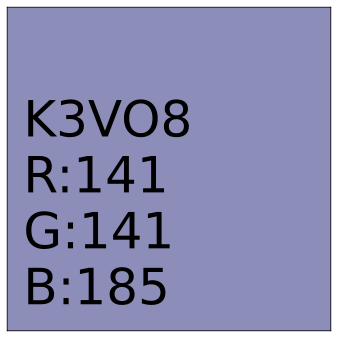

# CIE 1976 L\*a\*b\*

## L\*:60.15 a\*:9.44 b\*:-22.71

# CIE 1931 x,y

## x:0.2729 y:0.2637

---

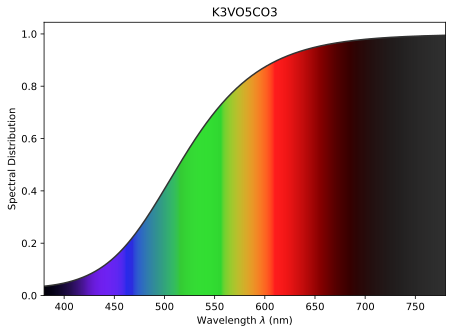

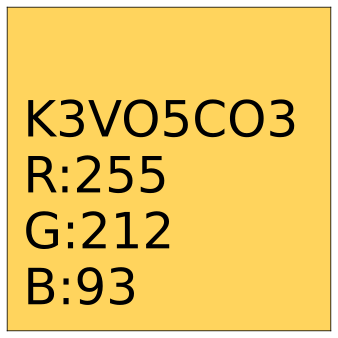

# CIE 1976 L\*a\*b\*

## L\*:86.69 a\*:3.09 b\*:63.14

# CIE 1931 x,y

## x:0.4293 y:0.4424

---

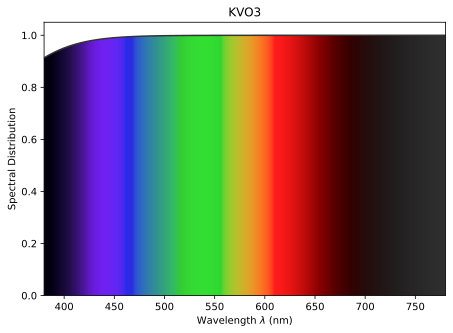

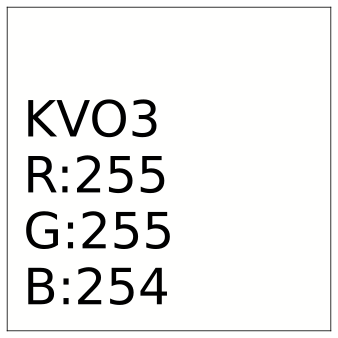

# CIE 1976 L\*a\*b\*

## L\*:99.98 a\*:-0.28 b\*:0.65

# CIE 1931 x,y

## x:0.3134 y:0.3303

---

In [5]:
#@title 5. Computational Colors

output.no_vertical_scroll()

#color_calc_comp('BandGapData/data/computational/K3VO8_fixed_03.txt', title='K3VO8', energy_units='ev', data_type='absorbance', scale=160)
#color_calc_comp('BandGapData/data/computational/K3VO5CO3_fixed_03.txt', title='K3VO5CO3', energy_units='ev', data_type='absorbance', scale=700)
#color_calc_comp('BandGapData/data/computational/KVO3_fixed_03.txt', title='KVO3', energy_units='ev', data_type='absorbance', scale=1)

color_calc_comp('DAC_Color/computational/simulated_spectra/K3VO8_fixed_03.txt', title='K3VO8', energy_units='ev', data_type='absorbance', scale=160)
color_calc_comp('DAC_Color/computational/simulated_spectra/K3VO5CO3_fixed_03.txt', title='K3VO5CO3', energy_units='ev', data_type='absorbance', scale=700)
color_calc_comp('DAC_Color/computational/simulated_spectra/KVO3_fixed_03.txt', title='KVO3', energy_units='ev', data_type='absorbance', scale=1)

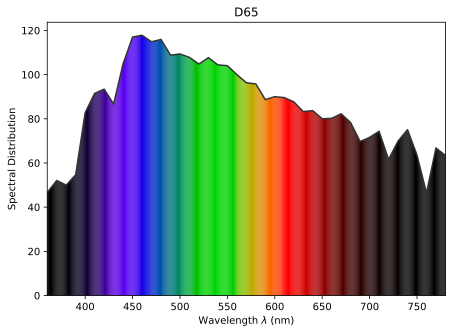

In [6]:
#@title 6. D65 Power Spectrum

plot_single_sd(colour.SDS_ILLUMINANTS["D65"], title='D65');

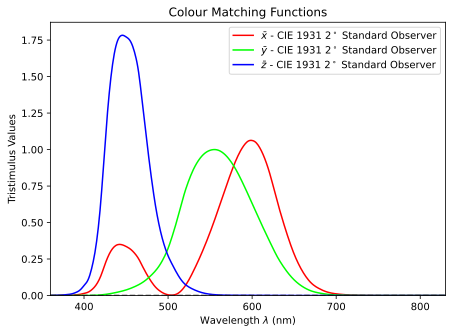

In [6]:
#@title 7. CIE 1931 $\bar{x}, \bar{y}, \bar{z}$ Tristimulus Functions

colour.plotting.plot_single_cmfs("CIE 1931 2 Degree Standard Observer", title='Colour Matching Functions');